In [1]:
cd /home/admin/projects/learn_miniai/

/home/admin/projects/learn_miniai


In [2]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, default_collate
from torch import tensor
import torchvision.transforms.functional as TF

from miniai.datasets import inplace
from miniai.datasets import show_images
from miniai.training import get_dls
from miniai.training import to_device

In [3]:
ls

miniai/  nbs/  settings.ini


## Review data

In [4]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dataset = load_dataset(name)

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
train_ds, val_ds = dataset['train'], dataset['test']

featy = train_ds.features[y]

In [6]:
image, label = train_ds[0].values()
image

In [7]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F08D1E5B550>,
 'label': 9}

In [8]:
featy = train_ds.features[y]

In [9]:
featy.int2str(label)

'Ankle boot'

In [10]:
len(featy.names)

10

In [11]:
@inplace
def image_2_tensor(b):
    for o in b:
        o[x] = TF.to_tensor(o[x])
        o[y] = tensor(o[y])

def collate_fn(b): 
    b = to_device(default_collate(image_2_tensor(b)))
    return b[x], b[y]

In [12]:
train_dl, val_dl = get_dls(train_ds, val_ds, bs=50, collate_fn=collate_fn)

In [13]:
xb, yb = next(iter(train_dl))

In [14]:
xb.shape, yb.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

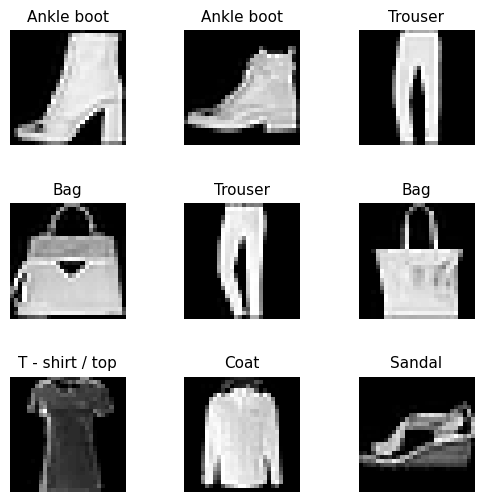

In [15]:
show_images(xb[0:9].to('cpu'), titles=[featy.int2str(i.item()) for i in yb])

## Warm up classify

In [16]:
from miniai.conv import conv
from torch import nn
from miniai.training import fit
from miniai.training import def_device
from torch import optim

bs = 256
lr = 0.4

In [17]:
model = nn.Sequential(conv(1,4), #14x14
                      conv(4,8), #7x7
                      conv(8,16), #4x4
                      conv(16,16), #2x2
                      conv(16,10, act=False), #2x2
                      nn.Flatten()
                     ).to(def_device)
model(xb).shape

torch.Size([50, 10])

In [18]:
epoch = 3
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=lr)
train_dl, val_dl = get_dls(train_ds, val_ds, bs=bs, collate_fn=collate_fn)

In [19]:
fit(epoch, model, loss_func, opt, train_dl, val_dl)

Loss 0.0017. Acc = 0.68
Loss 0.0011. Acc = 0.79
Loss 0.0010. Acc = 0.82


## Auto-encoder

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
def deconv(ni, nf, ks=3, stride=1, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)]
    if act == True: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [22]:
model = nn.Sequential(                 #28x28
                      nn.ZeroPad2d(2), #32x32
                      conv(1,2), #16x16
                      conv(2,4), #8x8
#                       conv(4,8), #4x4
#                       deconv(8,4), #8x8
                      deconv(4,2), #16x16
                      deconv(2,1, act=False), #8x8
                      nn.ZeroPad2d(-2),
                      nn.Sigmoid()
                     ).to(def_device)
model(xb).shape

torch.Size([50, 1, 28, 28])

In [23]:
epoch = 5
lr = 0.04
loss_func = nn.MSELoss()
opt = optim.AdamW(model.parameters(), lr=lr)
train_dl, val_dl = get_dls(train_ds, val_ds, bs=bs, collate_fn=collate_fn)

In [24]:
import numpy as np

def eval(model, dl, loss_func):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for xb, yb in dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            total_loss.append(loss.item())
    print(f"{np.mean(total_loss):.4f}")

eval(model, val_dl, loss_func)

0.1680


In [25]:
def fit(epoch, model, loss_func, opt, train_dl, val_dl):
    for _ in range(epoch):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, val_dl, loss_func)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.1)
fit(epoch, model, loss_func, opt, train_dl, val_dl)

0.0420


In [ ]:
pred = model(xb)
show_images(pred.detach()[0:9].to('cpu'), titles=[featy.int2str(i.item()) for i in yb])

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.01)
fit(epoch, model, loss_func, opt, train_dl, val_dl)

In [ ]:
pred = model(xb)
show_images(pred.data[0:9].to('cpu'), titles=[featy.int2str(i.item()) for i in yb])

In [ ]:
show_images(xb[0:9].to('cpu'), titles=[featy.int2str(i.item()) for i in yb])